In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/noise2noise/Proj/Miniproject_2

Mounted at /content/drive
/content/drive/MyDrive/noise2noise/Proj/Miniproject_2


In [15]:
%reload_ext autoreload

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
from torch import empty, cat, arange
from torch.nn.functional import fold, unfold
from pathlib import Path

from others.container import Sequential
from others.optimizer import SGD
from others.loss import MSE
from others.convolution import Conv2d, Upsampling
from others.activations import ReLU, Sigmoid
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
data_path = "../../dataset/"
train_path = data_path + "train_data.pkl"
val_path = data_path + "val_data.pkl"
train_input, train_target = torch.load(train_path)
val_input, val_target = torch.load(val_path)

# Rescale the tensor between [0, 1]
train_input = train_input.float() / 255.0
train_target = train_target.float() / 255.0
val_input = val_input.float() / 255.0
val_target = val_target.float() / 255.0

In [5]:
torch.set_grad_enabled(False)

In [252]:
#torch.manual_seed(42)

class Model():
    '''Model'''
    def __init__(self) -> None:
        '''Instantiate model + optimizer + loss function + any other stuff needed'''
        # Instantiate model

        self.model = Sequential(
            Conv2d(3, 64, (3,3), stride=2, padding=1), # 10, 15, 15
            ReLU(),
            Conv2d(64, 256, (3,3), stride=2, padding=1), # 20, 7, 7
            ReLU(),
            Upsampling(256, 64, (4,4), stride=2, padding=1), # 10, 15, 15 
            ReLU(),
            Upsampling(64, 3, (4,4), stride=2, padding=1), # 3, 32, 32
            Sigmoid()
        )
        # Instantiate optimizer
        

        # Choose loss function
        self.criterion = MSE()

        # Default mini batch size
        self.batch_size = 100

        # Default path to save model
        #self.model_path = Path(__file__).parent / "bestmodel.pth"

    def load_pretrained_model(self) -> None:
        '''This loads the parameters saved in bestmodel.pth into the model'''
        # Load parameters
        
        with open('./bestmodel.pth', 'rb') as f:
            params = pickle.load(f)
        # Update parameters
       
        for i in range(len(self.model.param())):

            self.model.param()[i][0].zero_().add_(params[i])

    def train(self, train_input: torch.Tensor, train_target: torch.Tensor, 
        num_epochs=50, verbose=False, lr=1e-4,  momentum=0.99) -> None:
        ''' Train model

        :train_input: tensor of size (N, C, H, W) containing a noisy version of the images

        :train_target: tensor of size (N, C, H, W) containing another noisy version of the same
        images, which only differs from the input by their noise

        :num_epochs: (int) number of training epochs, default = 50

        :verbose: (bool) Choice of verbose execution, default = False
        '''
        self.model.to(device)
        self.optimizer = SGD(self.model.param(), learning_rate=lr, momentum=momentum)
       


        for e in range(num_epochs):
            epoch_loss = 0.0
            i =  0
            for inputs, targets in zip(train_input.split(self.batch_size), 
                                       train_target.split(self.batch_size)):
                inputs, targets = inputs.to(device), targets.to(device)
                output = self.model.forward(inputs)
                #print(output.shape)
            
               
                
                epoch_loss = self.criterion.forward(output, targets)
                self.optimizer.zero_grad()
                d_loss = self.criterion.backward()
               
                self.model.backward(d_loss)
                self.optimizer.step()
              
                
                print(f"\r{i} {epoch_loss}", end="")
                i+=1
               

            if verbose:
                print(" ")
                print(f'Epoch #{e+1}: MSE Loss = {epoch_loss:.6f}')

        # Save at the end of the training
        #torch.save(self.model, 'bestmodel1.pth')


    def predict(self, test_input) -> torch.Tensor:
        '''
        :test_input: tensor of size (N1, C, H, W) with values in range 0-255 that has to
        be denoised by the trained or the loaded network.

        :returns a tensor of size (N1, C, H, W) with values in range 0-255
        '''
        self.model.to("cpu")
        return self.model.forward(test_input).mul(255)


In [235]:
model = Model()

In [269]:
model.train(train_input, train_target, num_epochs=10, verbose=True, lr=0.05, momentum=0.999)

499 0.02058730088174343 
Epoch #1: MSE Loss = 0.020587
499 0.02058718167245388 
Epoch #2: MSE Loss = 0.020587
314 0.01932648755609989

KeyboardInterrupt: ignored

In [12]:
def compute_psnr(x, y, max_range=1.0):
    print(x.shape)
    assert x.shape == y.shape and x.ndim == 4
    return (
        20 * torch.log10(torch.tensor(max_range)) - 
        10 * torch.log10(((x-y) ** 2).mean((1,2,3))).mean()
    )

In [265]:
import pickle
model.model.to("cpu")
params = [p for p, g in model.model.param()]
with open('./bestmodel.pth', 'wb') as f:
            pickle.dump(params, f)

In [270]:
model = Model()
model.load_pretrained_model()

In [271]:
model_outputs = []
model.model.to('cpu')
for b in tqdm(range(0, val_input.size(0), 100)):
    output = model.model(val_input.narrow(0, b, 100))
    model_outputs.append(output)
model_outputs = torch.cat(model_outputs, dim=0) 

output_psnr = compute_psnr(model_outputs, val_target)
print(f"[PSNR {2}: {output_psnr:.2f} dB]")

100%|██████████| 10/10 [00:01<00:00,  6.30it/s]

torch.Size([1000, 3, 32, 32])
[PSNR 2: 20.48 dB]


In [231]:
import matplotlib.pyplot as plt

def show_img(img, axis=None):
    rgb_img = (img.clip(0,1)*255).to(torch.uint8)
 
    plt.imshow(rgb_img.permute(1, 2, 0) )

x = val_input[:1]
y = model.model(x)

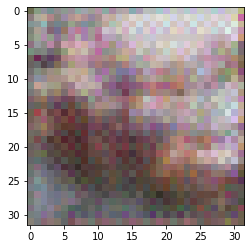

In [232]:
show_img(y[0])

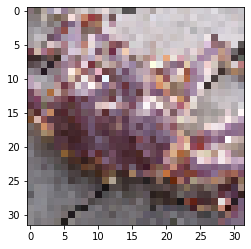

In [102]:
show_img(x[0])

### Test model

### 2. Build noise2noise model using Pytorch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
torch.set_grad_enabled(True)